# Objective

Before we start manipulate/clean the data, the first task is to understand the structure of this dataset and answer the following questions:
1.       How many records? How many columns? What is the data type for each column?

2.       What are the independent variables? What is the dependent variable?

3.       Percentage of missing data for each column

4.       Variable cleaning and transformation

- [1. Shape & Type](#1.-Shape-&-Type)
    - [1.1 How many records? How many columns?](#1.1-How-many-records?-How-many-columns?)
    - [1.2 What is the data type for each column?](#1.2-What-is-the-data-type-for-each-column?)


- [2. What are the independent variables? What is the dependent variable](#2.-What-are-the-independent-variables?-What-is-the-dependent-variable?)


- [3. Percentage of missing data in each column](#3.-Percentage-of-missing-data-for-each-column)


- [4. Variable cleaning and transformation](#4.-Variable-cleaning-and-transformation)
    - [4.1 Date transform](#4.1-Date-transform)
    - [4.2 Boolean transform](#4.2-Boolean-transform)


- [5. Visualize missing value vs. time](#5.-Visualize-missing-value-vs.-time)
    - [Conclusion](#Conclusion)

***
#### First we need to load the necessary packages

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
data = pd.read_csv('Consumer_Complaints.csv', parse_dates = True)

### 1. Shape & Type 

#### 1.1 How many records? How many columns?

In [5]:
shape = data.shape
print('The data set contains {} records, {} columns'.format(shape[0], shape[1]))

The data set contains 871873 records, 18 columns


#### 1.2 What is the data type for each column?

__Pandas by default load any column that is not numeric as "object." We need some inspection to understand what data type should be assigned to each column.__

In [6]:
# Only Complaint ID is parsed as int64
data.dtypes

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object

In [7]:
# Take a quick look at what's inside
data.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


** Looks like most of the columns are regular strings, with the following exceptions: **

|Column|Type|
|--|--|
|**Date received**|Date|
|**Date sent to company**|Date|
|**Timely response?**|Boolean|
|**Consumer disputed?**|Boolean|

***

### 2. What are the independent variables? What is the dependent variable?

** The goal of our task **: Build a classification model to predict whether a consumer complain would get timely response. 

In [8]:
ID = 'Complaint ID'
target = 'Timely response?'
feature = [col for col in data.columns.tolist() if col != target and col != ID]
print('Dependent Variable: {}\n'.format([target]))
print('Independent Variables:')
pprint(feature)

Dependent Variable: ['Timely response?']

Independent Variables:
['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Consumer disputed?']


***

### 3. Percentage of missing data for each column

In [9]:
def na_summary(df):
    shape = df.shape
    return df.apply(lambda x: round(np.count_nonzero(x.isnull()) / shape[0], 2))

In [10]:
print(na_summary(data))

Date received                   0.00
Product                         0.00
Sub-product                     0.27
Issue                           0.00
Sub-issue                       0.54
Consumer complaint narrative    0.79
Company public response         0.72
Company                         0.00
State                           0.01
ZIP code                        0.01
Tags                            0.86
Consumer consent provided?      0.61
Submitted via                   0.00
Date sent to company            0.00
Company response to consumer    0.00
Timely response?                0.00
Consumer disputed?              0.12
Complaint ID                    0.00
dtype: float64


***

### 4. Variable cleaning and transformation

#### 4.1 Date transform

** We can parse the date using `pd.to_datetime()`, but this fucntion with default setting will take forever to process 870k rows. **

** Since we already know the format of the column, let's define the format for the parser **

In [11]:
formater = '%m/%d/%Y'
data['Date received'] = pd.to_datetime(data['Date received'], format=formater)
data['Date sent to company'] = pd.to_datetime(data['Date sent to company'], format=formater)

In [12]:
data['receive_year'] = data['Date received'].apply(lambda x: x.year)
data['receive_month'] = data['Date received'].apply(lambda x: x.month)
data['receive_day'] = data['Date received'].apply(lambda x: x.day)

#### 4.2 Boolean transform

In [13]:
def bool_transformer(value):
    # If the value is already boolean, skip it.
    if type(value) == 'bool':
        return value
    if value == 'Yes':
        return True
    elif value == 'No':
        return False
    # return Null if missing value

In [14]:
data['Timely response?'] = data['Timely response?'].apply(bool_transformer)
data['Consumer disputed?'] = data['Consumer disputed?'].apply(bool_transformer)

In [15]:
data.dtypes

Date received                   datetime64[ns]
Product                                 object
Sub-product                             object
Issue                                   object
Sub-issue                               object
Consumer complaint narrative            object
Company public response                 object
Company                                 object
State                                   object
ZIP code                                object
Tags                                    object
Consumer consent provided?              object
Submitted via                           object
Date sent to company            datetime64[ns]
Company response to consumer            object
Timely response?                          bool
Consumer disputed?                      object
Complaint ID                             int64
receive_year                             int64
receive_month                            int64
receive_day                              int64
dtype: object

### 5. Visualize missing value vs. time

** Let's see if there is a pattern in missing values that relates to the time **

In [16]:
na_data = data[feature].isnull()
na_data[['receive_year', 'receive_month']] = data[['receive_year', 'receive_month']]
na_summary = na_data.groupby(
    ['receive_year', 'receive_month'], as_index=False
).apply(lambda x: x.sum() / x.count())

In [17]:
def plot_na_pattern(df, feature):
    for col in feature:
        ax = sns.heatmap(df.pivot('receive_year', 'receive_month', col),
           vmin = 0, vmax = 1, cmap = 'Reds')
        ax.set_title(col)
        plt.show()

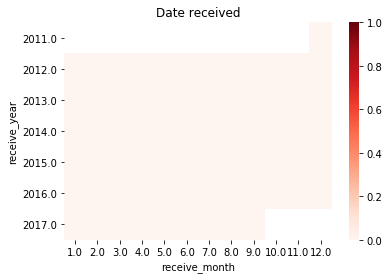

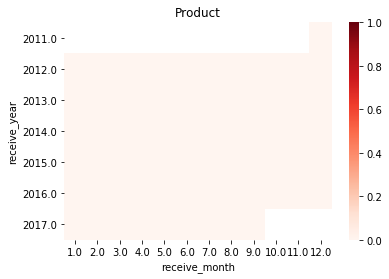

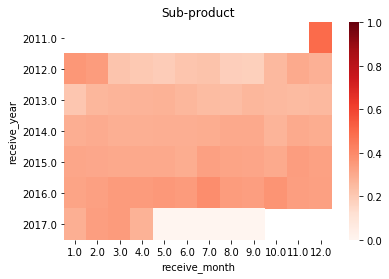

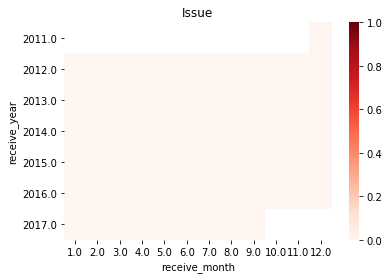

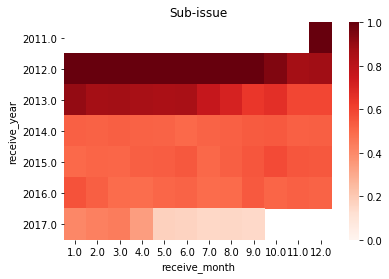

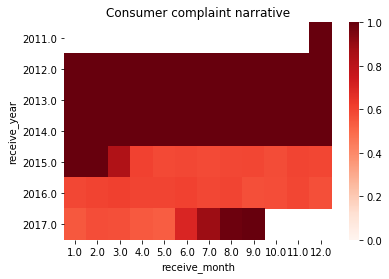

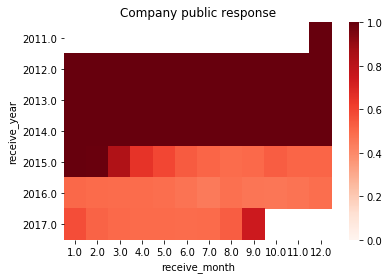

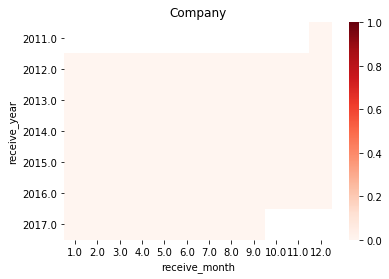

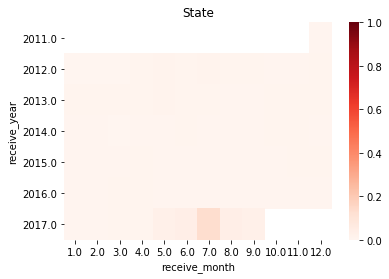

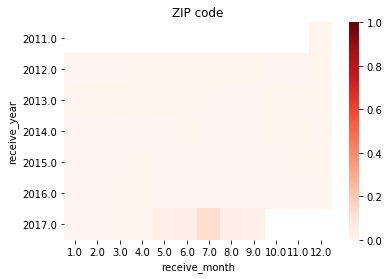

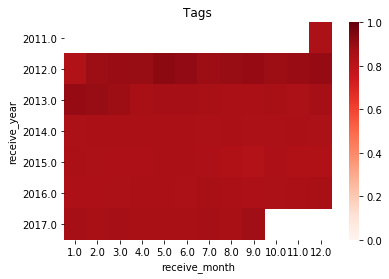

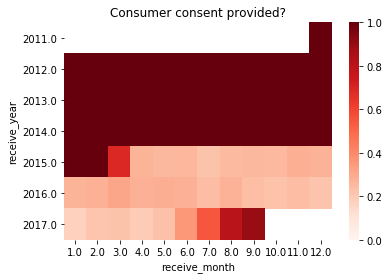

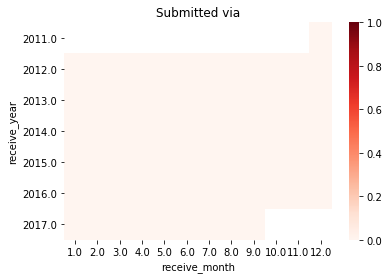

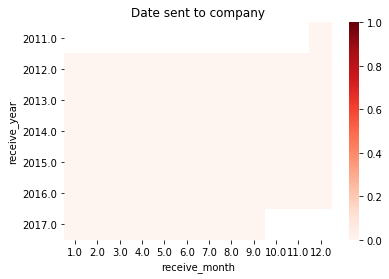

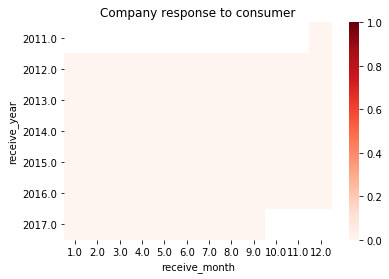

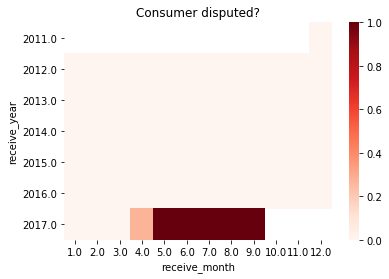

In [18]:
plot_na_pattern(na_summary, feature)

### Conclusion
** There is a clear pattern of missing values that changes over time. **